In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, make_scorer, accuracy_score

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss

In [2]:
with open('dec_flights_model.pickle','rb') as read_file:
    dec_flights = pickle.load(read_file)

In [3]:
dec_flights.drop(columns=['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay', 'dep_delay_indict','arr_delayed_indict'],axis=1,inplace=True)
dec_flights.columns

Index(['air_time', 'num_flights', 'distance', 'delay_level', 'airline_AS',
       'airline_B6', 'airline_DL', 'airline_EV', 'airline_F9', 'airline_HA',
       ...
       'dest_SFO', 'dest_SHD', 'dest_SLC', 'dest_SLN', 'dest_SPN', 'dest_STS',
       'dest_SWO', 'dest_TPA', 'dest_UIN', 'dest_VEL'],
      dtype='object', length=148)

### Train_test_spilt

In [4]:
X1, y1 = dec_flights.drop('delay_level',axis=1), dec_flights['delay_level']

from imblearn.under_sampling import RandomUnderSampler
X, y = RandomUnderSampler(random_state=42).fit_sample(X1,y1)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

#further spilt into 60% and 20% for train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

Using TensorFlow backend.


In [5]:
from collections import Counter
Counter(y)

Counter({1: 121432, 0: 121424})

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [7]:
#initialise list
model = ['Logistic', 'Bernoulli', 'DecisionTree', 'RandomForest']
accuracy = []
f1 = []
auc = []
recall = []

### Logistic Regression

In [8]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logistic.score(X_train, y_train)))
print("Validate: {:6.2f}%".format(100*logistic.score(X_val, y_val)))
print("Test set: {:6.2f}%".format(100*logistic.score(X_test, y_test)))
print("Log-loss: {:6.4f}".format(log_loss(y_test, logistic.predict_proba(X_test))))

/Users/kelseyheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score for logistic regression is
Training:  60.67%
Validate:  60.15%
Test set:  60.36%
Log-loss: 0.6586


In [9]:
logistic_pred = logistic.predict(X_val)
print('Logistic Results:')
print(confusion_matrix(y_val,logistic_pred))
print(classification_report(y_val, logistic_pred))
logistic_score = logistic.fit(X_train, y_train).score(X_val, y_val)
print('Logistic score: %f' % logistic_score)

Logistic Results:
[[18291 11996]
 [12197 18230]]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60     30287
           1       0.60      0.60      0.60     30427

    accuracy                           0.60     60714
   macro avg       0.60      0.60      0.60     60714
weighted avg       0.60      0.60      0.60     60714



/Users/kelseyheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic score: 0.601525


In [10]:
logistic_pred = logistic.predict(X_test)
logistic_f1 = f1_score(logistic_pred, y_test)

In [11]:
logistic_y_score = logistic.predict_proba(X_val)[:, 1]

#calculate roc curve
logistic_fpr, logistic_tpr, logistic_auc_thresholds = roc_curve(y_val, logistic_y_score)

#calculate auc
auc_logistic = roc_auc_score(y_val, logistic_y_score)
print('AUC: %.3f' % auc_logistic)

AUC: 0.646


In [12]:
#precision-recall auc

recall_logistic = recall_score(y_train, logistic.predict(X_train))
print('Recall: %.3f' % recall_logistic)

Recall: 0.605


In [13]:
accuracy.append(logistic_score)
print('Accuracy: ',accuracy)

f1.append(logistic_f1)
print('F1: ', f1)

auc.append(auc_logistic)
print('AUC: ', auc)

recall.append(recall_logistic)
print('Recall: ', recall)

Accuracy:  [0.6015251836479231]
F1:  [0.6022443684201828]
AUC:  [0.6463980726081482]
Recall:  [0.6046590846656777]


In [ ]:
#most updated graph parameters!!!!!
feature_importance = abs(logistic.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(1,figsize=(10,20))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='#65b1b2')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=13)
featax.set_xlabel('Relative Feature Importance')

featax.spines['right'].set_visible(False)
featax.spines['top'].set_visible(False)
featax.spines['bottom'].set_visible(True)
featax.spines['left'].set_visible(True)

featax.patch.set_visible(False)

#plt.savefig('feature_importance.jpg', transparent=True);
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Naive Bayes

In [14]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
nb.score(X_test,y_test)

print("The score for BernoulliNB is")
print("Training: {:6.2f}%".format(100*nb.score(X_train, y_train)))
print("Training: {:6.2f}%".format(100*nb.score(X_val, y_val)))
print("Test set: {:6.2f}%".format(100*nb.score(X_test, y_test)))
print("Log-loss: {:6.4f}".format(log_loss(y_test, nb.predict_proba(X_test))))

The score for BernoulliNB is
Training:  58.80%
Training:  58.54%
Test set:  58.31%
Log-loss: 0.6729


In [15]:
nb_pred = nb.predict(X_val)
print('Bernoulli Results:')
print(confusion_matrix(y_val,nb_pred))
print(classification_report(y_val, nb_pred))
nb_score = nb.fit(X_train, y_train).score(X_val, y_val)
print('Bernoulli score: %f' % nb_score)

Bernoulli Results:
[[17049 13238]
 [11935 18492]]
              precision    recall  f1-score   support

           0       0.59      0.56      0.58     30287
           1       0.58      0.61      0.60     30427

    accuracy                           0.59     60714
   macro avg       0.59      0.59      0.59     60714
weighted avg       0.59      0.59      0.59     60714

Bernoulli score: 0.585384


In [16]:
nb_pred = nb.predict(X_test)
nb_f1= f1_score(y_test, nb_pred)
print(nb_f1)

0.5934729538738276


In [17]:
nb_y_score = nb.predict_proba(X_val)[:, 1]
#calculate roc curve
bernoulli_fpr, bernoulli_tpr, bernoulli_auc_thresholds = roc_curve(y_val, nb_y_score)

#calculate auc
auc_nb = roc_auc_score(y_val, nb_y_score)
print('AUC_bernoulli: %.3f' % auc_nb)

AUC_bernoulli: 0.619


In [18]:
recall_nb = recall_score(y_train, nb.predict(X_train))
print('Recall: %.3f' % recall_nb)

Recall: 0.612


In [19]:
accuracy.append(nb_score)
print('Accuracy: ',accuracy)

nb_f1 = f1_score(nb_pred, y_test)
f1.append(nb_f1)
print('F1: ', f1)

auc.append(auc_nb)
print('AUC: ', auc)

recall.append(recall_nb)
print('Recall: ', recall)

Accuracy:  [0.6015251836479231, 0.5853839312184999]
F1:  [0.6022443684201828, 0.5934729538738276]
AUC:  [0.6463980726081482, 0.6185485956329945]
Recall:  [0.6046590846656777, 0.6120652711389484]


### DecisionTree

In [20]:
tree = DecisionTreeClassifier(max_depth = 50)
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

print("The score for DecisionTreeClassifier is")
print("Training: {:6.2f}%".format(100*tree.score(X_train, y_train)))
print("Validate: {:6.2f}%".format(100*tree.score(X_val, y_val)))
print("Test set: {:6.2f}%".format(100*tree.score(X_test, y_test)))

The score for DecisionTreeClassifier is
Training:  96.96%
Validate:  55.70%
Test set:  55.93%


In [21]:
tree_pred = tree.predict(X_val)
print('Tree Results:')
print(confusion_matrix(y_val, tree_pred))
print(classification_report(y_val, tree_pred))
tree_score = tree.fit(X_train, y_train).score(X_val, y_val)
print('Tree score: %f' % tree_score)

Tree Results:
[[17087 13200]
 [13697 16730]]
              precision    recall  f1-score   support

           0       0.56      0.56      0.56     30287
           1       0.56      0.55      0.55     30427

    accuracy                           0.56     60714
   macro avg       0.56      0.56      0.56     60714
weighted avg       0.56      0.56      0.56     60714

Tree score: 0.556132


In [22]:
tree_pred = tree.predict(X_test)
tree_f1 = f1_score(y_test, tree_pred)

In [23]:
tree_y_score = tree.predict_proba(X_val)[:, 1]
#calculate roc curve
tree_fpr, tree_tpr, tree_auc_thresholds = roc_curve(y_val, tree_y_score)

#calculate auc
auc_tree = roc_auc_score(y_val, tree_y_score)
print('AUC: %.3f' % auc_tree)

AUC: 0.556


In [24]:
recall_tree = recall_score(y_train, tree.predict(X_train))
print('Recall: %.3f' % recall_tree)

Recall: 0.962


In [25]:
accuracy.append(tree_score)
print('Accuracy: ',accuracy)

tree_f1 = f1_score(tree_pred, y_test)
f1.append(tree_f1)
print('F1: ', f1)

auc.append(auc_tree)
print('AUC: ', auc)

recall.append(recall_tree)
print('Recall: ', recall)

Accuracy:  [0.6015251836479231, 0.5853839312184999, 0.5561320288566064]
F1:  [0.6022443684201828, 0.5934729538738276, 0.555982898928707]
AUC:  [0.6463980726081482, 0.6185485956329945, 0.555501733539598]
Recall:  [0.6046590846656777, 0.6120652711389484, 0.9620350530190649]


### RandomForest

In [26]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)
forest.score(X_train, y_train)

print("The score for Random Forest is")
print("Training: {:6.2f}%".format(100*forest.score(X_train, y_train)))
print("Training: {:6.2f}%".format(100*forest.score(X_val, y_val)))
print("Test set: {:6.2f}%".format(100*forest.score(X_test, y_test)))
print("Log-loss: {:6.4f}".format(log_loss(y_test, forest.predict_proba(X_test))))

The score for Random Forest is
Training:  99.24%
Training:  58.35%
Test set:  58.15%
Log-loss: 0.7386


In [27]:
forest_pred = forest.predict(X_val)
print('Forest Results:')
print(confusion_matrix(y_val, forest_pred))
print(classification_report(y_val, forest_pred))
forest_score = forest.fit(X_train, y_train).score(X_val, y_val)
print('Forest score: %f' % forest_score)

Forest Results:
[[17963 12324]
 [12965 17462]]
              precision    recall  f1-score   support

           0       0.58      0.59      0.59     30287
           1       0.59      0.57      0.58     30427

    accuracy                           0.58     60714
   macro avg       0.58      0.58      0.58     60714
weighted avg       0.58      0.58      0.58     60714

Forest score: 0.583012


In [28]:
forest_pred = forest.predict(X_test)
forest_f1 = f1_score(forest_pred, y_test)

In [29]:
forest_y_score = forest.predict_proba(X_val)[:, 1]
#calculate roc curve
forest_fpr, forest_tpr, forest_auc_thresholds = roc_curve(y_val, forest_y_score)

#calculate auc
auc_forest = roc_auc_score(y_val, forest_y_score)
print('AUC_forest: %.3f' % auc_forest)

AUC_forest: 0.616


In [30]:
recall_forest = recall_score(y_train, forest.predict(X_train))
print('Recall: %.3f' % recall_forest)

Recall: 0.992


In [31]:
accuracy.append(forest_score)
print('Accuracy: ',accuracy)

forest_f1 = f1_score(forest_pred, y_test)
f1.append(forest_f1)
print('F1: ', f1)

auc.append(auc_forest)
print('AUC: ', auc)

recall.append(recall_forest)
print('Recall: ', recall)

Accuracy:  [0.6015251836479231, 0.5853839312184999, 0.5561320288566064, 0.5830121553513193]
F1:  [0.6022443684201828, 0.5934729538738276, 0.555982898928707, 0.580426516779633]
AUC:  [0.6463980726081482, 0.6185485956329945, 0.555501733539598, 0.6155533584591979]
Recall:  [0.6046590846656777, 0.6120652711389484, 0.9620350530190649, 0.992231196088127]


### Graphs

In [32]:
print('Model: ', model)
print('Accuracy score: ', accuracy)
print('F1 score:', f1)
print('AUC score:', auc)
print('Precision recall:', recall)

Model:  ['Logistic', 'Bernoulli', 'DecisionTree', 'RandomForest']
Accuracy score:  [0.6015251836479231, 0.5853839312184999, 0.5561320288566064, 0.5830121553513193]
F1 score: [0.6022443684201828, 0.5934729538738276, 0.555982898928707, 0.580426516779633]
AUC score: [0.6463980726081482, 0.6185485956329945, 0.555501733539598, 0.6155533584591979]
Precision recall: [0.6046590846656777, 0.6120652711389484, 0.9620350530190649, 0.992231196088127]


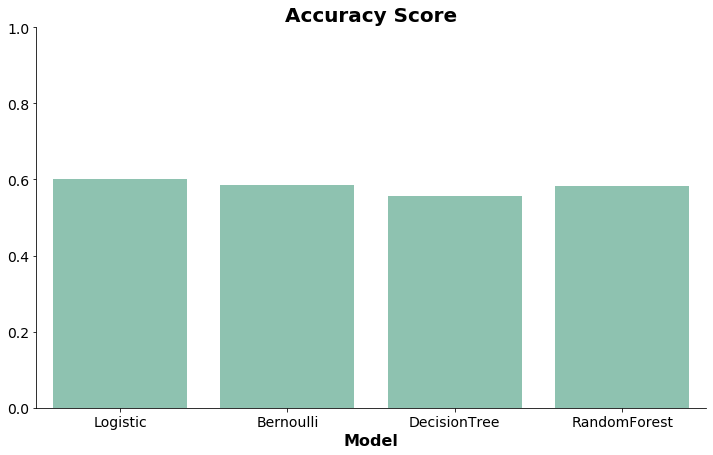

In [33]:
model=['Logistic', 'Bernoulli', 'DecisionTree', 'RandomForest']

plt.figure(figsize=(12,7))
sns.despine()
ax = sns.barplot(x=model, y=accuracy,color='#85cbb3')

plt.title('Accuracy Score', fontsize=20, fontweight='bold')

plt.xlabel('Model', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)

#plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.yticks(fontsize=14)
plt.ylim([0,1.0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('accuracy_score_undersample.jpg', transparent=True)

''

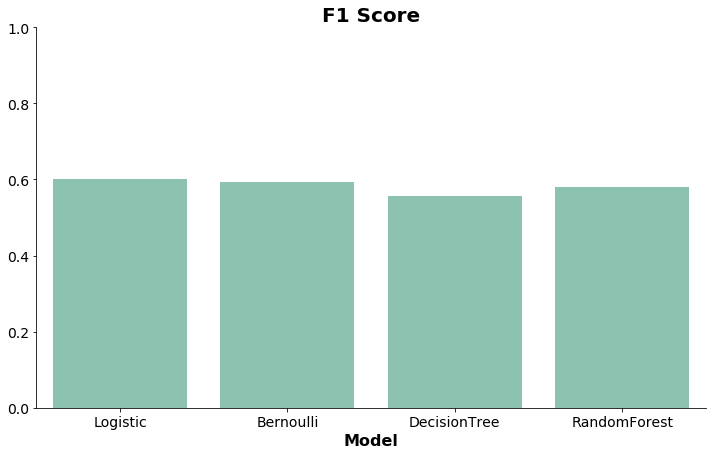

In [34]:
model=['Logistic', 'Bernoulli', 'DecisionTree', 'RandomForest']

plt.figure(figsize=(12,7))
sns.despine()
ax = sns.barplot(x=model, y=f1,color='#85cbb3')

plt.title('F1 Score', fontsize=20, fontweight='bold')

plt.xlabel('Model', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)

#plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.yticks(fontsize=14)
plt.ylim([0,1.0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('f1_score_undersample.jpg', transparent=True)
;

''

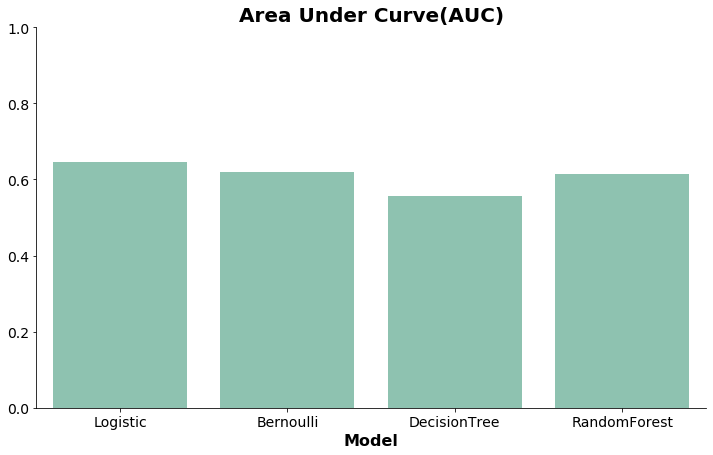

In [35]:
model=['Logistic', 'Bernoulli', 'DecisionTree', 'RandomForest']

plt.figure(figsize=(12,7))
sns.despine()
ax = sns.barplot(x=model, y=auc,color='#85cbb3')

plt.title('Area Under Curve(AUC)', fontsize=20, fontweight='bold')

plt.xlabel('Model', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)

#plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.yticks(fontsize=14)
plt.ylim([0,1.0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('auc_undersample.jpg', transparent=True)
;

''

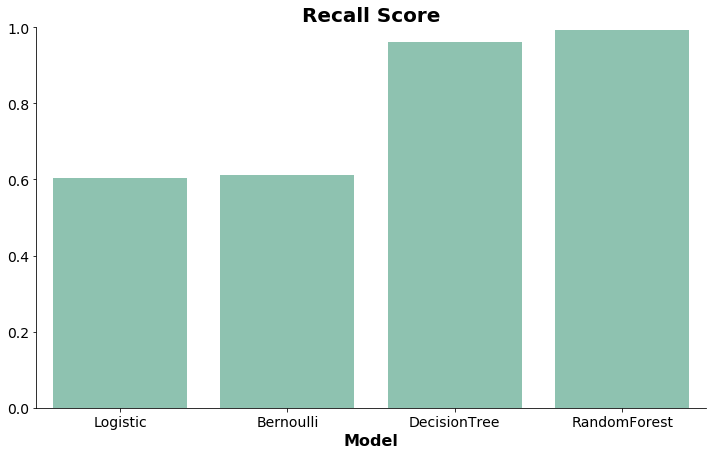

In [36]:
model=['Logistic', 'Bernoulli', 'DecisionTree', 'RandomForest']

plt.figure(figsize=(12,7))
sns.despine()
ax = sns.barplot(x=model, y=recall,color='#85cbb3')

plt.title('Recall Score', fontsize=20, fontweight='bold')

plt.xlabel('Model', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)

#plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.yticks(fontsize=14)
plt.ylim([0,1.0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('recall_undersample.jpg', transparent=True)
;

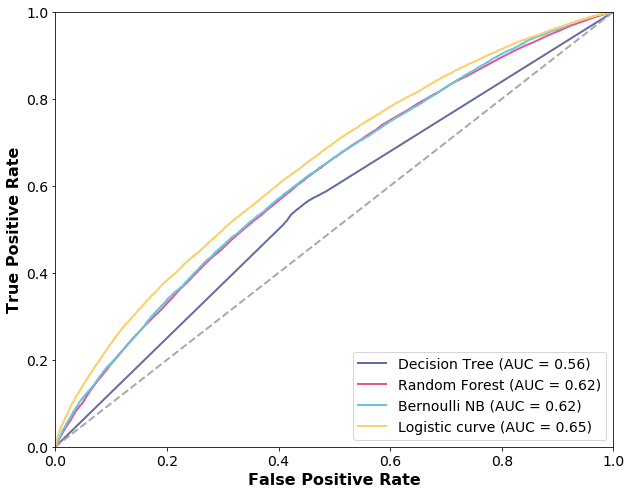

In [38]:
fig = plt.figure(figsize=(10,8))
lw = 2

# plt.plot(knn_fpr, knn_tpr, color='#474f5b',
#          lw=lw, label='KNN curve (AUC = %0.2f)' % auc_knn)
plt.plot(tree_fpr, tree_tpr, color='#626e9d',
         lw=lw, label='Decision Tree (AUC = %0.2f)' % auc_tree)
plt.plot(forest_fpr, forest_tpr, color='#e6568d',
         lw=lw, label='Random Forest (AUC = %0.2f)' % auc_forest)
plt.plot(bernoulli_fpr, bernoulli_tpr, color='#66c5de',
         lw=lw, label='Bernoulli NB (AUC = %0.2f)' % auc_nb)
plt.plot(logistic_fpr, logistic_tpr, color='#fad16a',
         lw=lw, label='Logistic curve (AUC = %0.2f)' % auc_logistic)


plt.plot([0, 1], [0, 1], color='darkgrey', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 16, weight='bold')
plt.xticks(fontsize=14)
plt.ylabel('True Positive Rate', fontsize = 16, weight='bold')
plt.yticks(fontsize=14)
# plt.title('AUC Curves', fontsize = 20)
plt.legend(loc="lower right", fontsize = 14)

plt.savefig('auc_curves_undersample.jpg')
plt.show()